### **Project COVID**

Insight questions on COVID-19 dataset:
- Which countries have the top 5 highest total deaths?
- Which country's has highest % of population vaccinated? Lowest?

- What is the correlation between human development index (HDI) and total deaths per country or icu_patients_per_million?

- Is population density a strong indicator of death rate in country?

- Correlation between COVID-19 stringency index at location and new cases per million

In [260]:
#Importing libraries and tools
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import fancyimpute
import plotly.express as px
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import BayesianRidge, LinearRegression 
from fancyimpute import IterativeImputer
import matplotlib.pyplot as plt 

In [261]:
#Reading the csv data
covid_data= pd.read_csv('owid-covid-data.csv')

In [262]:
# Taking a look at the first 5 rows of data
covid_data.head(5)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN


In [263]:
# Looking at info on the dataset
covid_data.info() #Data consists of float64 and object data types, there are unequal counts of the majority of the data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166326 entries, 0 to 166325
Data columns (total 67 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   iso_code                                    166326 non-null  object 
 1   continent                                   156370 non-null  object 
 2   location                                    166326 non-null  object 
 3   date                                        166326 non-null  object 
 4   total_cases                                 163293 non-null  float64
 5   new_cases                                   163133 non-null  float64
 6   new_cases_smoothed                          161150 non-null  float64
 7   total_deaths                                145451 non-null  float64
 8   new_deaths                                  145487 non-null  float64
 9   new_deaths_smoothed                         143390 non-null  float64
 

`covid_data` contains 67 columns x 166326 rows, consists mainly of object and float64 (numeric) data types, and has 85.0+ MB memory usage.

### Cleaning Data
To prepare `covid_data` for effective data analysis to optimize insights, any duplicates, missing data, and outliers will be addressed below.

In [264]:
#checking for duplicates in all columns
covid_duplic_data = covid_data.duplicated()

# total count of duplicates in covid_data
total_duplic_data = sum(covid_duplic_data == True)

print("Total duplicates found:", total_duplic_data)

Total duplicates found: 0


0 duplicates were found in the `covid_data` dataset, so removing rows is unnecessary so far.

In [265]:
#Separating categoric and numeric variables
covid_data_num_vars = covid_data.select_dtypes(include='number')
covid_data_categ_vars = covid_data.select_dtypes(include='category')

print(covid_data_num_vars)
print(covid_data_categ_vars)


        total_cases  new_cases  new_cases_smoothed  total_deaths  new_deaths  \
0               5.0        5.0                 NaN           NaN         NaN   
1               5.0        0.0                 NaN           NaN         NaN   
2               5.0        0.0                 NaN           NaN         NaN   
3               5.0        0.0                 NaN           NaN         NaN   
4               5.0        0.0                 NaN           NaN         NaN   
...             ...        ...                 ...           ...         ...   
166321     236871.0      491.0             413.000        5395.0         0.0   
166322     237503.0      632.0             416.286        5396.0         1.0   
166323     237503.0        0.0             362.286        5396.0         0.0   
166324     238739.0     1236.0             467.429        5397.0         1.0   
166325     239019.0      280.0             459.429        5397.0         0.0   

        new_deaths_smoothed  total_case

In [266]:
#Finding amount of missing data in all columns
cols_missing_data = covid_data.isnull().sum()

#Calculating % missing data per column
percent_missing_data = round((cols_missing_data/covid_data.shape[0])*100,2)

#Identifying the top 15 columns missing data (by %)
top_cols_missing_data = percent_missing_data.nlargest(15)
print(top_cols_missing_data)


weekly_icu_admissions                      96.73
weekly_icu_admissions_per_million          96.73
excess_mortality_cumulative_absolute       96.58
excess_mortality_cumulative                96.58
excess_mortality                           96.58
excess_mortality_cumulative_per_million    96.58
weekly_hosp_admissions                     93.43
weekly_hosp_admissions_per_million         93.43
total_boosters                             89.46
total_boosters_per_hundred                 89.46
icu_patients                               85.89
icu_patients_per_million                   85.89
hosp_patients                              85.20
hosp_patients_per_million                  85.20
new_vaccinations                           77.49
dtype: float64


The top eight columns, `weekly_icu_admissions` to `weekly_hosp_admissions_per_million`, have the highest % of missing data by roughly 4% compared to the remaining seven columns. These columns would be interesting to explore, although they are mostly missing data, so Multiple Imputer will be applied to fill in for this issue.

In [287]:
# Applying Multiple Imputer to all numeric columns with missing data:

#1. Imputing missing values of numeric data
num_cols= covid_data.select_dtypes(include=[np.number]).columns.tolist()
catg_cols= covid_data.select_dtypes(include=[object]).columns.tolist()


#1. Calling IterativeImputer() 
#mice_imputer = IterativeImputer()

#2. Creating an instance of IterativeImputer
mice_imputer_inst = IterativeImputer(estimator = BayesianRidge(), max_iter=15, random_state=0) 


imputed_numeric_data = mice_imputer_inst.fit_transform(covid_data[num_cols])

#3. Creating a dataframe from imputed data
imputed_num_df = pd.DataFrame(imputed_numeric_data, columns=num_cols)

covid_data[num_cols]= imputed_num_df

print(covid_data.head(5))



  iso_code continent     location        date  total_cases  new_cases  \
0      AFG      Asia  Afghanistan  2020-02-24          5.0        5.0   
1      AFG      Asia  Afghanistan  2020-02-25          5.0        0.0   
2      AFG      Asia  Afghanistan  2020-02-26          5.0        0.0   
3      AFG      Asia  Afghanistan  2020-02-27          5.0        0.0   
4      AFG      Asia  Afghanistan  2020-02-28          5.0        0.0   

   new_cases_smoothed  total_deaths  new_deaths  new_deaths_smoothed  ...  \
0          255.608123  33336.042076  154.975449           161.890115  ...   
1          251.939563  33336.767541  154.969893           161.889283  ...   
2          251.939563  33336.767541  154.969893           161.889283  ...   
3          251.939563  33336.767541  154.969893           161.889283  ...   
4          251.939563  33336.767541  154.969893           161.889283  ...   

   female_smokers  male_smokers  handwashing_facilities  \
0        7.042217     39.427734        

Now, all missing numeric data has been filled in with multiple imputation. Below, all numeric columns will be double-checked for missing data.

In [268]:
#Finding amount of missing data in all columns
imputed_cols_missing_data = covid_data[num_cols].isnull().sum()

#Calculating % missing data per column
imputed_percent_missing_data = round((imputed_cols_missing_data/covid_data.shape[0])*100,2)

#Identifying the top 15 columns missing data (by %)
imputed_top_cols_missing_data = imputed_percent_missing_data.nlargest(15)
print(imputed_top_cols_missing_data)

total_cases                        0.0
new_cases                          0.0
new_cases_smoothed                 0.0
total_deaths                       0.0
new_deaths                         0.0
new_deaths_smoothed                0.0
total_cases_per_million            0.0
new_cases_per_million              0.0
new_cases_smoothed_per_million     0.0
total_deaths_per_million           0.0
new_deaths_per_million             0.0
new_deaths_smoothed_per_million    0.0
reproduction_rate                  0.0
icu_patients                       0.0
icu_patients_per_million           0.0
dtype: float64


All numeric columns are confirmed to contain no missing data, so next, the outliers will be handled.

In [269]:
# Using describe to find outliers
print(covid_data.describe())

        total_cases     new_cases  new_cases_smoothed  total_deaths  \
count  1.663260e+05  1.663260e+05        1.663260e+05  1.663260e+05   
mean   2.530178e+06  1.158777e+04        1.143990e+04  5.468729e+04   
std    1.529316e+07  8.361205e+04        8.129420e+04  2.827558e+05   
min    1.000000e+00 -1.379775e+04       -1.199841e+04 -7.019398e+03   
25%    2.118000e+03  1.000000e+00        7.000000e+00  1.080000e+02   
50%    2.920900e+04  8.900000e+01        1.161430e+02  1.474000e+03   
75%    3.419412e+05  1.231000e+03        1.304429e+03  1.817874e+04   
max    4.451295e+08  4.206334e+06        3.444237e+06  5.995245e+06   

          new_deaths  new_deaths_smoothed  total_cases_per_million  \
count  166326.000000        166326.000000            166326.000000   
mean      171.188498           168.972361             29423.986555   
std       778.390990           759.045343             51267.255659   
min      -191.958716          -630.463489                 0.001000   
25%       

The majority of maximums and minimums appear to deviate largely from the mean, indicating these are outliers. Next, a boxplot will be used to visualize these numeric outliers, starting with `icu_patients_per_million` in North America.

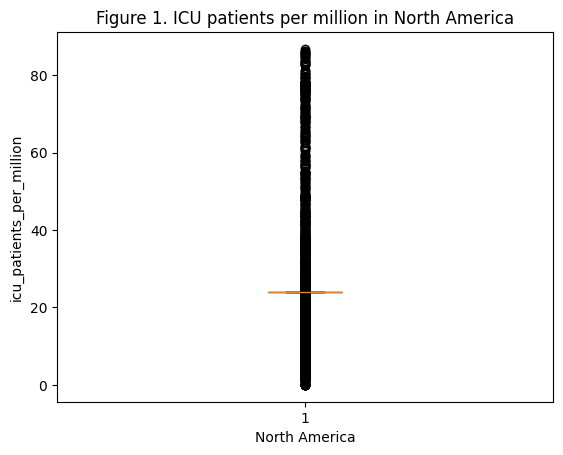

In [295]:
# Filtering for data collected from North America
N_America_data = covid_data[covid_data['continent'] == 'North America']

# Creating the boxplot for icu_patients_per_million in North America
plt.boxplot(N_America_data['icu_patients_per_million'], vert=True, patch_artist=True)
plt.title('Figure 1. ICU patients per million in North America')
plt.xlabel('North America')
plt.ylabel('icu_patients_per_million')
plt.show()

Outliers in `icu_patients_per_million` within a country likely reflects the incremental rise in ICU patients as data is collected over time, and is also expected to vary between countries due to multiple factors such as government policies, economic stability, quality of medical care across regions, etc.. In this case, removing true outliers is not applicable because it reflects real differences that occur over time and between countries.

In [296]:
# Exporting clean data to a .csv file
covid_data.to_csv('cleaned_data.csv', index=False)